In [54]:
import viz
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [55]:
def get_id(model, dataset):
    df = pd.read_csv('./experiments_buffer/results.txt', names=range(8))
    df[1] = df[1].str.strip()
    df[3] = df[3].astype(str).astype(float)
    id_model = df[(df[0]==model)&(df[1]==dataset)&(df[7]==1)][df[3]==df[3].max()][2]
    print(id_model)
    return model, dataset, id_model

In [56]:
DATASET = 'heart'
MODEL = 'ann'
OOD = True

In [58]:
ann_url = viz.get_model_url('ann', DATASET, '1619416781')
ann_args = viz.load_args(ann_url)
x_train, x_val, x_test, y_train, y_val, y_test, ood_x, ood_y = viz.load_data(ann_args)
ann_model = viz.load_model(ann_url, x_train.shape[1], y_train.shape[1], ann_args)

heart


In [18]:
jehm_url = viz.get_model_url('jehm', DATASET, '1619531270')
jehm_args = viz.load_args(jehm_url)
jehm_model = viz.load_model(jehm_url, x_train.shape[1], y_train.shape[1], jehm_args)

Samples: 20


In [19]:
jem_url = viz.get_model_url('jem', DATASET, '1616778501')
jem_args = viz.load_args(jem_url)
jem_model = viz.load_model(jem_url, x_train.shape[1], y_train.shape[1], jem_args)

AttributeError: 'Namespace' object has no attribute 'model'

In [60]:
# Best one thus far 1618054012
# gen ood closest to true ood 1618055607
# gen closes to true ood with not as many o_n steps 1618062683
# Tested with Yining 1617986270

jehmo_url = viz.get_model_url('jehmo', DATASET, '1619378656')
jehmo_args = viz.load_args(jehmo_url)
jehmo_model = viz.load_model(jehmo_url, x_train.shape[1], y_train.shape[1], jehmo_args)

Samples: 20


In [63]:
# Best one thus far 1618054012
# gen ood closest to true ood 1618055607
# gen closes to true ood with not as many o_n steps 1618062683
# Tested with Yining 1617986270

jehmomix_url = viz.get_model_url('jehmo_mix', DATASET, '1619538107')
jehmomix_args = viz.load_args(jehmomix_url)
jehmomix_model = viz.load_model(jehmomix_url, x_train.shape[1], y_train.shape[1], jehmomix_args)

Samples: 20


In [ ]:
jehmo_model.n_epochs

In [ ]:
#jemo_url = viz.get_model_url('jemo', DATASET, '1615528859')
#jemo_args = viz.load_args(jemo_url)
#jemo_model = viz.load_model(jemo_url, x_train.shape[1], y_train.shape[1], jemo_args)

In [64]:
plt.rcParams["figure.figsize"] = (20,3)
def leave_cvx_hull(model_list, x, y):
    fig, axs = plt.subplots(1, 3)
    fig.suptitle('Leaving cvx hull')
    for i, y_lbl in enumerate(['accuracy', 'confidence', 'entropy']):
        for model in model_list:
            y_list = []
            for u in range(0, 1000, 100):
                y_plot=0
                t = np.random.uniform(-1, 1, size=x.shape)
                py_x = tf.nn.softmax(model(x + u*t))
                if y_lbl=='entropy':
                    y_plot = -tf.reduce_mean(tf.reduce_sum(py_x*tf.math.log(py_x), axis=1))
                if y_lbl=='accuracy':
                    y_plot = tf.reduce_mean(tf.cast(
                        tf.argmax(py_x, axis=1)==tf.argmax(y, axis=1), tf.float32))
                if y_lbl=='confidence':
                    y_plot = tf.reduce_mean(tf.reduce_max(py_x, 1))
                y_list.append(y_plot.numpy())
            axs[i].plot(np.array(y_list), label=model.name)
        axs[i].set(xlabel='perturbation', ylabel=y_lbl+' (mean)')
        axs[i].legend()

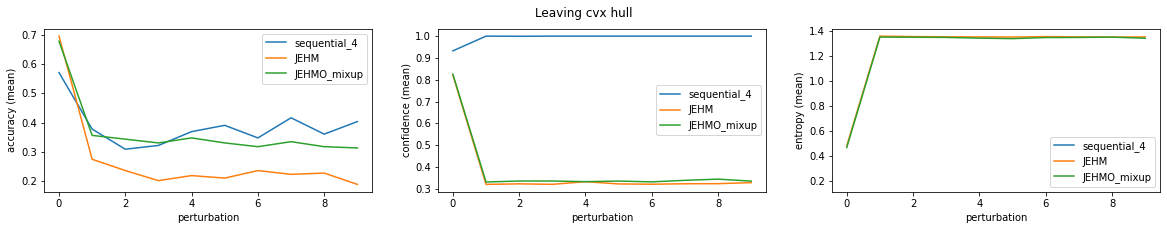

In [65]:
leave_cvx_hull([ann_model, jehmo_model, jehmomix_model], x_train, y_train)

In [66]:
def confidence_plot(models, x, xo):
    for model in models:
        p_in = tf.reduce_max(tf.nn.softmax(model(x)), axis=1)
        p_out = tf.reduce_max(tf.nn.softmax(model(xo)), axis=1)
        plt.ylabel('Frequency')
        plt.xlabel('Confidence')
        plt.xlim([0, 1])
        plt.hist(p_in.numpy(), bins=20, label=f'In {model.name}', alpha=.5)
        plt.hist(p_out.numpy(), bins=20, label=f'Out {model.name}', alpha=.5)
        plt.legend()

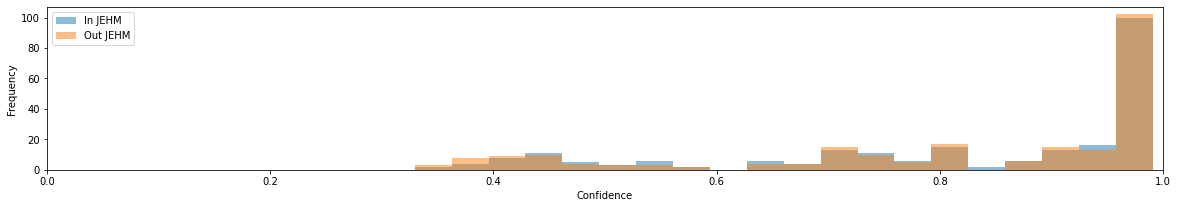

In [68]:
xgo = jehmo_model.sample_ood(x_train)
confidence_plot([jehmo_model], x_train, xgo)

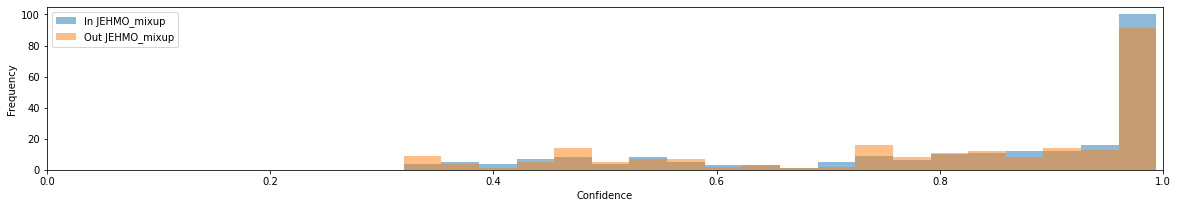

In [85]:
xgo1 = jehmomix_model.sample_ood(x_train)
confidence_plot([jehmomix_model], x_train, xgo1)

In [ ]:
confidence_plot([jehm_model], x_test, ood_x)

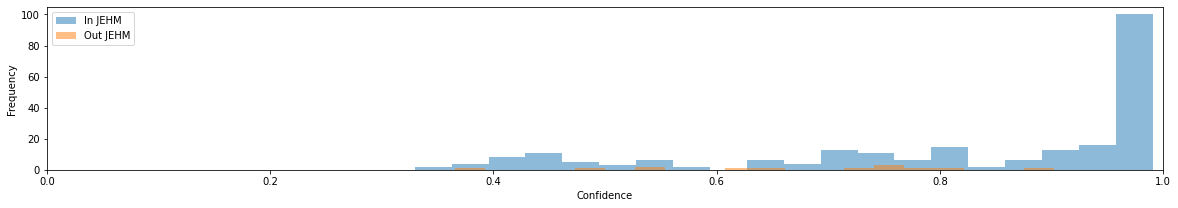

In [69]:
confidence_plot([jehmo_model], x_train, ood_x)

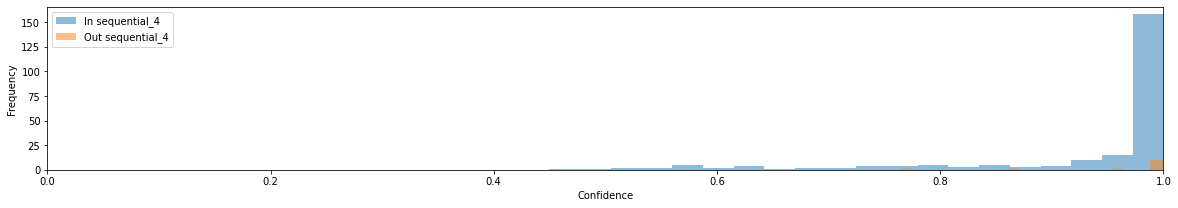

In [70]:
confidence_plot([ann_model], x_train, ood_x)

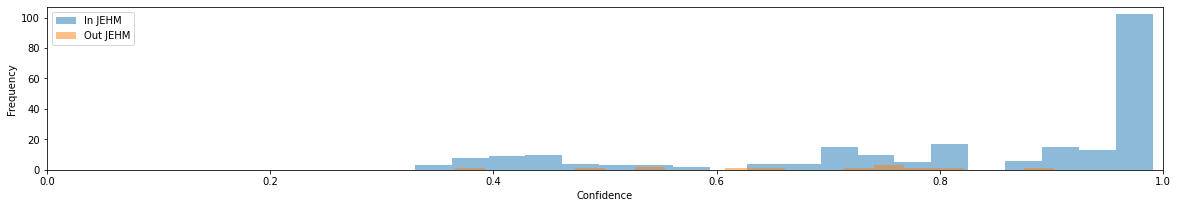

In [71]:
confidence_plot([jehmo_model], xgo, ood_x)

(13, 20)


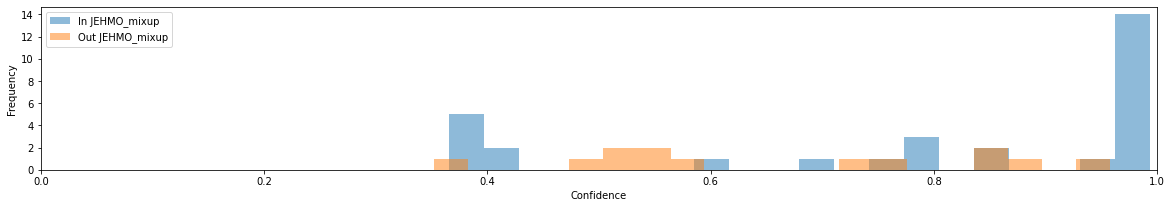

In [72]:
print(ood_x.shape)
confidence_plot([jehmomix_model], x_test, ood_x)

In [73]:
def analyze_features(model, x, xo, idx):
    plt.figure()
    plt.hist(x[:, idx], bins=20, color='blue', label='sample', alpha=.5)
    plt.hist(xo[:, idx], bins=20, color='red', label='ood', alpha=.5)
    if model.name in ['JEM', 'JEHM']:
        xgo = model.sample_ood(x)
        plt.hist(xgo[:, idx].numpy(), bins=20, color='green', label='gen_o', alpha=.5)
    plt.legend()
    plt.show()

In [ ]:
for i in range(4):
    analyze_features(jehmo_model, x_train, ood_x, i)

In [ ]:
def calibration_plot(model, x, y, ece):
    py_x = tf.nn.softmax(model(x))
    p = tf.reduce_max(py_x, axis=1).numpy()
    
    hat_y = tf.argmax(py_x, axis=1)
    y = tf.argmax(y, axis=1)
    acc = tf.cast(hat_y==y, tf.float32).numpy()
    
    acc_list = []
    p_list = []
    for i in np.arange(0,1,.1):
        idx_u = p<=i+.1
        idx_l = i<=p
        idx = idx_l*idx_u
        if p[idx]!=[]:
            p_list.append(np.mean(p[idx]))
            acc_list.append(np.mean(acc[idx]))
        else:
            p_list.append(0)
            acc_list.append(0)
    print(p_list)
    print(acc_list)
    plt.title(f'Calibration {model.name}: {ece}')
    plt.ylabel('Frequency')
    plt.xlabel('ACC/Conf')
    plt.xlim([0, 1])
    plt.bar(np.arange(0,1,.1), height=acc_list, width=.1,
            color='blue', label='accuracy', alpha=.75)
    plt.bar(np.arange(0,1,.1), height=p_list, width=.1,
            color='red', label='confidence', alpha=.75)
    plt.legend()

In [ ]:
calibration_plot(ann_model, x_test, y_test, 0)

In [ ]:
calibration_plot(jehmo_model, x_test, y_test, 0)

In [ ]:
calibration_plot(jem_model, x_test, y_test, 0)

In [ ]:
calibration_plot(jehmo_model, np.concatenate([x_test, ood_x], axis=0), np.concatenate([y_test, ood_y], axis=0), 0)

In [ ]:
calibration_plot(ann_model, np.concatenate([x_test, ood_x], axis=0), np.concatenate([y_test, ood_y], axis=0), 0)

In [ ]:
calibration_plot(jem_model, np.concatenate([x_test, ood_x], axis=0), np.concatenate([y_test, ood_y], axis=0), 0)

In [ ]:
loss = ann_model.evaluate(x_test, y_test, return_dict=True)

In [ ]:
loss

In [80]:
import umap

#reduce = umap.UMAP()
#z = reduce.fit_transform(np.concatenate([x_train, ood_x], axis=0))


In [87]:
#import umap
ood_reduce = umap.UMAP()
ood_z = ood_reduce.fit_transform(np.concatenate([x_train, ood_x, xgo1.numpy()], axis=0))

/home/jyn/miniconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

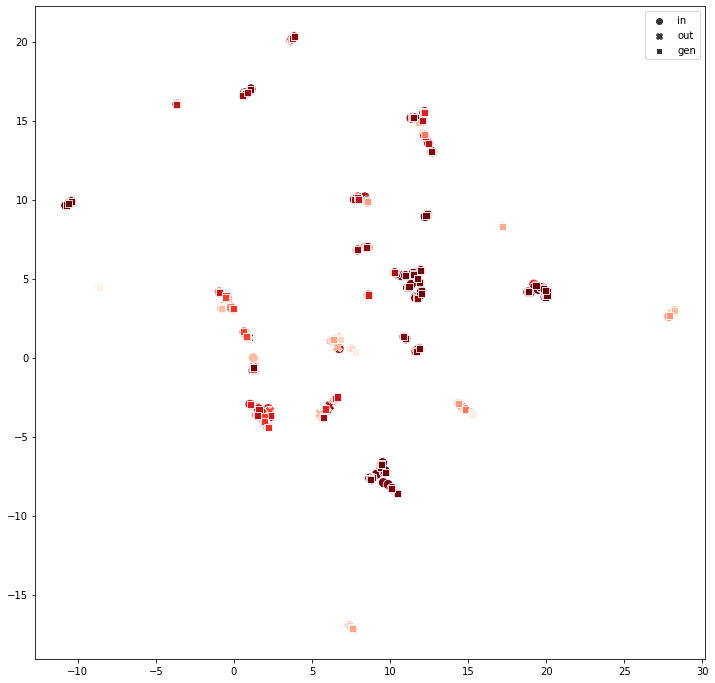

In [88]:
import seaborn as sns
py_x = tf.nn.softmax(jehmomix_model(np.concatenate([x_train, ood_x, xgo1])))
p = tf.reduce_max(py_x, axis=1).numpy()
markers = ['in']*len(x_train) + ['out']*len(ood_x) + ['gen']*len(xgo1.numpy())
plt.figure(figsize=[12,12])
sns.scatterplot(*ood_z.T, c=p, style=markers, cmap='Reds', s=100)
plt.colorbar()
#plt.show()